# 1. Data

The first step, as always, is to download the data you will be working on. You can download the data to build the system here. Please download the 3 files which can be found under the description ['Answers to questions', 'Comments to questions', 'Comments to answers']

In particular, each file will contain the following information:

Answers to questions - User u answered user v's question at time t
Comments to questions - User u commented on user v's question at time t
Comments to answers - User u commented on user v's answer at time t
Unless specified differently we will handle the 3 graphs together, therefore as a first step please think about a nice and appropriate manner to merge them. You are free to merge them as you prefer, but we do expect the output graph to be a weighted gragh. For instance, imagine you have a user X has answered to a question and comment from user Y. In the combined graph we expect you to have a weighted link between these two users. How you construct this weight is fully up to you :). If the algorithm we request you does not have a weighted variant please mention it clearly and convert the weighted graph into an unweighted one.

Some recommendations that might be helpful for dealing with the data is:

The date is provided with a very high precision, please round it to a reasonable value (e.g. day, hours, etc. whatever you feel makes more sense)
You might also see that there are several answers/comments which the user answer do to themselves... please deal with these accordingly and explain what you have decided to do.
We are aware that the data is a lot. For this reason we typically ask you to only focus on a smaller intrerval of time. Please test all your implementations on a sufficiently large interval of time, and use this in your benefit to get the best possible results.


In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm
import collections
import math
from datetime import *
from tabulate import tabulate


In [2]:
#Data Loading

#data for answer to the question
a2q=pd.read_csv('stac_a2q.txt',sep=' ', names=['u','v','t']) 
#data for comment to the answer
c2a=pd.read_csv('stac_c2a.txt',sep=' ', names=['u','v','t'])
#data for comment to the question
c2q=pd.read_csv('stac_c2q.txt',sep=' ', names=['u','v','t'])
dfs = [a2q,c2a,c2q]

In [3]:
print(a2q.shape,c2a.shape,c2q.shape)


(17823525, 3) (25405374, 3) (20268151, 3)


In [3]:
a2q['type'] = 'a2q'
c2a['type'] = 'c2a'
c2q['type'] = 'c2q' #adding type column to dataframes
a2q['weight'] = 1.
c2a['weight'] = 1.
c2q['weight'] = 1. #adding weights column initial value of 1
a2q=a2q.sort_values('t')
cqa=c2a.sort_values('t')
cqq=c2q.sort_values('t') #sorting by time
    

In [5]:
#checking data set
a2q.head()

,u,v,t,type,weight
0,9,8,1217567877,a2q,1.0
1,1,1,1217573801,a2q,1.0
2,13,1,1217606247,a2q,1.0
3,17,1,1217617639,a2q,1.0
4,48,2,1217618182,a2q,1.0


In [6]:
c2a.head()

,u,v,t,type,weight
0,1,91,1220713630,c2a,1.0
1,3,91,1220713792,c2a,1.0
2,380,350,1220715736,c2a,1.0
3,4642,2257,1220734307,c2a,1.0
4,4642,1324220,1220735746,c2a,1.0


In [7]:
c2q.head()

,u,v,t,type,weight
0,4550,4550,1220729190,c2q,1.0
1,242,184,1220733503,c2q,1.0
2,4213,4946,1220768149,c2q,1.0
3,91,91,1220768295,c2q,1.0
4,2658,1874,1220771891,c2q,1.0


In [4]:
#we then write a function to find out the minimum and the maximum of a specific dataframe
def time(data,minimum,maximum): 
    m = data['t'].min()
    M = data['t'].max()
    if m < minimum:
        minimum = m 
    if M > maximum:
        maximum = M
    return minimum, maximum

In [5]:
def date_to_timestamp(s): #convert date in format '04 March, 2009' to timestamp
    d = datetime.strptime(s, "%d %B, %Y")
    d = datetime.timestamp(d)
    return d

In [6]:
def timestamp_to_date(timestamp): #convert timestamp to date
    d = datetime.fromtimestamp(timestamp)
    d = d.strftime("%d %B, %Y")
    return d

In [7]:
#for the fact that there are several answers/comments which the user 
#answer do to themselves, we gotta eliminate those rows for avoiding 
#self loop fact.
def fungraph(df,time_window,autofeed=0):
    if autofeed == 0: 
        df=df[df['u']!=df['v']]
#Then we will also remove rows according to the interval selected    
    df = df[df['t'].between(time_window[0], time_window[1])]
    D = df[['u','v']]
    D = D[D.duplicated(keep=False)]
    D = D.groupby(list(D)).apply(lambda x: tuple(x.index)).tolist()
    for d in D:
        ind = list(d)
        val = len(ind)
        drop = ind[:-1]
        df.at[ind[-1], 'weight'] = val
        df = df.drop(index = drop)
#now we will make the graph from the dataframes    
    Graph = nx.from_pandas_edgelist(df, 'u', 'v', ['t', 'type', 'weight'], create_using = nx.MultiDiGraph())
    return Graph

In [8]:
m = 10**(10)
M = 0
m, M = time(a2q, m, M)
m, M = time(c2a, m, M)
m, M = time(c2q, m, M)
print(timestamp_to_date(m)+'; '+ timestamp_to_date(M)) #the total time period of the data

01 August, 2008; 06 March, 2016


In [9]:
#here we choose the interval
interval = ('04 March, 2009', '12 March, 2009')
interval = (date_to_timestamp(interval[0]),date_to_timestamp(interval[1]))
df_a2q = fungraph(a2q, interval)
df_c2a = fungraph(c2a, interval)
df_c2q= fungraph(c2q, interval)
Graph = nx.compose_all([df_a2q, df_c2a, df_c2q]) #merging all the graphs


In [10]:
def filtering(Graph,interval):
    lista=[]
    interval=(date_to_timestamp(interval[0]),date_to_timestamp(interval[1]))

    for u,v,att in Graph.edges(data=True):
        if not interval[0] <= att['t'] <= interval[1]:
            lista.append((u, v))
    [Graph.remove_edge(u,v) for (u,v) in lista]
    return Graph

# 2. Implementation of the backend

The goal of this part is the implementation of a unique system that has ... different functionalities. The program takes in input always a number i in [1,...]: given the input, the program has to run Functionality i, applied to the graph you create from the downloaded data.

# Functionality 1 - Get the overall features of the graph

It takes in input:

One of the 3 graphs
The output should return:

Whether the graph is directed or not
Number of users
Number of answers/comments
Average number of links per user
Density degree of the graph
Whether the graph is sparse or dense


In [11]:
def get_feats(Graph):
    Nuser = []
    dircted = []
    feats=[]
    #checking if the graph is directed
    interactions=0
    for i,j,attr in (Graph.edges(data=True)):
        if (Graph.has_edge(j,i)) and (interactions<=len(df_a2q.edges(data=True))/2) : 
            dircted.append(abs(attr['weight']-Graph.get_edge_data(j, i)[0]['weight']))
        if i not in Nuser: Nuser.append(i) 
        if j not in Nuser: Nuser.append(j)
        interactions += 1 
    if all(val == 0 for val in dircted):
        GraphDirected=False 
    else: GraphDirected=True
    #checking total user
    totusers = len(Nuser) 
    #Average number of links per user
    linkPerUser = 0
    densitydegree = 0
    graph = None
    if totusers>0: 
        #checking the number of answers and comments
        linkPerUser = interactions/totusers
        #checking for the graph density
        if GraphDirected: 
            densitydegree = 2*interactions/(totusers*(totusers-1))
        else:
            densitydegree = interactions/(totusers*(totusers-1))
        #checking for the graph type
        if densitydegree>0.5:
            graph='Dense'
        else:
            graph='Sparse'
            graph='Sparse'
     
    print("The graph is directed:",GraphDirected)
    print("Number of users:",Nuser)
    print("Number of answers/comments:",totuser)
    print("Average number of links per user:",linkPerUser)
    print("Density degree of the graph:",densitydegree)
    print("The Graph is",graph)
   

            


In [48]:
get_feats(Graph)

The graph is directed: True
Number of users: 7075
Number of answers/comments: 24819
Average number of links per user: 3.5079858657243816
Density degree of the graph: 0.0009917969651468425
The Graph is Sparse


# Functionality 2 - Find the best users!

It takes in input:

A user/node
An interval of time
One of the following metrics: Betweeness 1, PageRank, ClosenessCentrality 3, DegreeCentrality
The output should return:

The value of the given metric applied over the complete graph for the given interval of time
Give an explanaition regarding the features of the user based on all of the metrics (e.g. if the betweeness metric is high, what does this mean in practice, what if the betweeness is low but it has a high PageRank value, etc.)

# Closeness Certainity

It is the measure of a node $v$ is the reciprocal of the average shortest path distance beetween the node $v$ and all the other $n-1$ reachable nodes of graph.

$Closenessness = \frac{n-1}{\sum_{u\epsilon V \setminus\{v\}}d(v,u)}$

It measures how much a node is close, in terms of distance, to all the other nodes in the graph. Obviously because it is an inverted average, more this value is small, more the measure is good.


In [19]:
def shortestPath(Graph,source,target):
    #creating a list for unvisited nodes
    nodes=[]
    #crating a dictionary for the nodes and distances
    nodesDistance={}
    #creating a dictionary for the previous nodes
    nodePrevious={}
    for i in nx.nodes(Graph):
        nodesDistance.update({i:math.inf})
        nodePrevious.update({i:None})  
        nodes.append(i) 
    nodesDistance[source]=0 
    #the algo goes to the next steps after visitng all the nodes 
    while len(nodes) != 0: 
        distance=[] 
        for i in nodes:
            distance.append(nodesDistance[i])
        u=nodes[distance.index(min(distance))]
        nodes.remove(u)
        if u == target:
            break
        for i in Graph.neighbors(u):
            #checking the new distances for neighbors
            newdist = nodesDistance[u] + Graph[u][i][0]['weight']
            if nodesDistance[i] > newdist:
                nodesDistance[i]=newdist
                nodePrevious[i]=u
    if nodePrevious[target] == None:
        return ('Not possible', [-1])
    #a list for the path from source to target
    pathnode=target
    path=[pathnode]
    while pathnode != source:
        path.insert(0,nodePrevious[pathnode])
        pathnode = nodePrevious[pathnode]
    return nodesDistance[target], path

In [20]:
def Closeness(Graph,u,n): 
    x=0
    for v in tqdm(Graph.nodes):
        dist,path=shortestPath(Graph,u,v)
        if (dist!='Not possible') and (dist!=0):
            x+=int(dist)
    if x>0: return ((n-1)/x)
    else: raise('Error: sum=0')

In [21]:
Closeness(Graph,1,len(Graph))


100%|██████████| 7075/7075 [3:30:33<00:00,  1.79s/it]  


0.26861591038541865

# Beetweeness
It is the ratio between the number of all pairs shortest paths passing through  and the number of all possible shortest paths of a graph.

$Betweeness = \frac{\sum_{u,w\epsilon V \setminus\{v\}} \frac{g_{u,v}^v}{g_{u,v}}}{{n-1 \choose 2}}$



In [106]:
def Betweenness(Graph,q,n): 
#this one takes so much time on my pc
#we need to rerun it before submitting the hw
#or highlight the fact that we dont run it for 
#the running time issues.
    x=0
    y=0
    for i in tqdm(Graph.nodes):
        for j in (Graph.nodes):
            distance,path = shortestPath(Graph,i,j)
            if (distance!='Not possible') and (distance!=0):
                y = y + int(distance)
                if q in path:
                    x = x + int(distance)
    A = 2*x/y
    B = (n*n)-(3*n)+2
    if B>0: return A/B
    else: raise('infinity')

In [ ]:
Betweenness(Graph,1,len(Graph))

  0%|          | 0/7075 [00:00<?, ?it/s]

In [26]:
def dist(Graph, u, metric, time_interval, alpha=0.2):   
    G1=Graph.copy()
    G1=filtering(G1,time_interval)
    values = get_feats(Graph)
    n = values[1]
    if metric == 'Betweeness':
        return Betweenness(G1,u,n)
    elif metric == 'PageRank':
        return funPR(G1, u, alpha, n)
    elif metric == 'Closeness':
        return Closeness(G1,u,n)
    elif metric == 'Degree':
        return (G1.degree(int(u))/(n-1))
    else:
        raise('Metric not allowed')


In [101]:
dist(Graph,1,'Degree',('04 March, 2009', '05 March, 2009'))

0.0002827254735651682

# PageRank
PageRank computes a ranking of the nodes in the graph  based on the structure of the incoming links. It measures the probability to arrive at the given node by randomly surfing around the nodes of a graph. To compute the PageRank we first create the adjacency matrix of the graph, then build the $P^{RW}$ (random walk) matrix, and after that we assign alpha value as 0.2 to create the  matrix using the formula below.

$P=\frac{\alpha}{n}M_1+(1-\alpha)P^{RW}$



In [25]:
#we first create a function for creating the adjacent matrix
def adjMat(Graph,n):
    if n==0: raise ('nothing found')
    else:
        x={}
        for i,j in sorted(list(Graph.edges())):
            x[(i,j)]=1
    return x

#a function that returns dictionary with nodes
#as keys and index in matrix as value
def posiiton(Graph):
    x={}
    counter=0
    for i in sorted(Graph.nodes):
        x[i]=counter
        counter = counter + 1
        return x
    
def funP(Graph,mat,position,n):
    keys = list(mat.keys())
    c = Counter(u for u,v in keys) 
    for source in sorted(list(Graph)):
        for (u,v) in keys:
            if source == u and c[source] > 0:
                mat[(u,v)] = 1/c[source] 
    keys = list(mat.keys())
    M=np.zeros(shape=(n,n)) 
    for (u,v) in keys: 
        value=mat[(u,v)]
        i=position[u]
        j=position[v]
        M[i][j]=value
    return M

#function for creating the P matrix
#from given alpha and P^{RW}
def matP(M, alpha, n):
    P=(alpha/n*np.ones((n,n)))+((1-alpha)*(M))   
    return P
    

In [24]:
def funPR(Graph, u, alpha, n, T=100): 
    mat = adjMat(Graph,n) 
    mapp = posiiton(Graph)
    mat = funP(Graph,mat,mapp,n)
    P = matP(mat, alpha, n)
    ind=mapp[u]
    start = random.randint(0,n)
    key_list = list(mapp.keys())
    val_list = list(mapp.values())
    s = key_list[val_list.index(start)] 
    print(('initial node {}').format(s))
    q0=np.zeros((n,1))
    q0[start]=1
    store_value=[]
    conv=False
    for t in tqdm(range(T)):
        q = np.matmul(q0.T, np.linalg.matrix_power(P, t)) 
        if (t>0) and (np.array_equal(q, store_value[-1])):
            print(('converged in {} steps').format(t-1))
            q=store_value[-2] 
            conv=True
            break
        store_value.append(q)
    if conv == False: print("no converging")
    return q[0][ind]

# Functionality 3 - Shortest Ordered Route


It takes in input:

An interval of time
A sequence of users p = [p_2, ..., p_n-1]
Initial user p_1 and an end user p_n
Implement an algorithm that returns the shortest walk that goes from user p_j to p_n, and that visits in order the nodes in p. The choice of p_j and p_n can be done randomly (or if it improves the performance of the algorithm you can also define it in any other way)

Consider that:

The algorithm needs to handle the case that the graph is not connected, thus not all the nodes in p are reachable from p_1. In such scenario, it is enough to let the program give in output the string "Not possible".
That the graph is weighted
Since we are dealing with walks, you can pass more than once on the same node p_i, but you have to preserve order. E.g.: if you pass through p_2 and you are going to p_3, you can pass through p_10, but once you will be in p_9, you will have to go back to p_10 as well.


In [102]:
def path(Graph,time_interval,users,source,target):
    Graph2 = Graph.copy()
    Graph2 = filtering(Graph2,time_interval)
    shortestpath = shortestPath(Graph2,source,users[0])
    dist = shortestpath[0]
    path = shortestpath[1]
    if dist == 'Not possible':
        return 'Not possible'
    
    for i in range(len(users)-1):
        shortestpath = shortestPath(Graph2,users[i],users[i+1])
        if shortestpath[0] == 'Not possible':
            return 'Not possible'
        dist += shortestpath[0]
        path.extend(shortestpath[1][1:])
        
    shortestpath = shortestPath(Graph2,users[-1],target)
    if shortestpath[0] == 'Not possible':
                     return 'Not possible'
            
        
    dist += shortestpath[0]
    path.extend(shortestpath[1][1:]) 
    
   
    return dist,path 

In [69]:
path(Graph,('04 March, 2009', '05 March, 2009'),[72859,1585],414876, 53055)

(3.0, [414876, 72859, 1585, 53055])


# Functionality 4 - Disconnecting graphs
It takes in input:

Two different intervals of time (disjoint or not), which will lead to two different graphs, G_1 (associated to interval 1) and G_2 (associated to interval 2)
Two users which are unique to each interval of time (user_1 only appears in interval 1, while user_2 only appears in interval 2)
The function should return the minimum number of links (considering their weights) required to disconnect the two users.

In [103]:
def disconnect(Graph,time_interval,u1,u2):
    
    #graph from the interval of time
    G_tot = Graph.copy()  
    G_tot = filtering(G_tot,time_interval)
    path = shortestPath(G_tot,u1,u2)[1]
    
    if path == [-1]:
        return 'the two nodes are disconnected'
    
    #Initializing the weight of the links to cut, the number of links and the edges to cut
    weight = 0
    num_link = 0
    edge = (path[0],path[1])
    edges_cut = []
    while path != [-1]:
        min_weight = math.inf 
        
        for i in range(len(path)-1):
            j = i + 1
            if G_tot[path[i]][path[j]][0]['weight'] < min_weight:
                min_weight = G_tot[path[i]][path[j]][0]['weight']
                edge = (path[i],path[j])  
            weight += min_weight  
        #Updating the number of links to cut and the edges to cut
        num_link += 1
        edges_cut.append(edge)
        G_tot.remove_edge(*edge) #removing the edge to cut from the graph
        path = shortestPath(G_tot,u1,u2)[1]
    print('atleast' +  str(num_link) + 'links to cut with a total weight of ' + str(weight))    
    return num_link, edges_cut

In [104]:
disconnect(Graph,('04 March, 2009', '05 March, 2009'),414876,1585)

atleast1links to cut with a total weight of 2.0


(1, [(414876, 72859)])

# 3. Implementation of the frontend

In this section, we ask you to build the visualizations for users’ queries results. We also expect you to showcase plots which can give us the most insight as possible and comment them accordingly.

Visualization 1 - Visualize the overall features of the graph
Output a table with all of the information requested. The visualization should also generate a plot of the density distribution of the graph provided as input.

Visualization 2 - Visualize the best user!
Plot the input node and a subset of its neighbouring nodes such that the user can get a grasp of the importance of this input node. Also split the interval of time into equidistant ranges of time and show the metric evolution over time.

Visualization 3 - Visualize the Shortest Ordered Route
Once the user runs Functionality 3, we want the system to show in output the Shortest Ordered Route.

Visualization 4 - Visualize disconnecting graphs
Show a visualization of the links needed to be removed in order to disconnect both graphs.

For each of the visualization, you can add more 'fancy' stuff. Therefore, you can go deeper, adding more features, and making the visualization even more detailed! But, the important thing is that there are at least the requested features.



# Visualization 1
Visualize the overall features of the graph Output a table with all of the information requested. The visualization should also generate a plot of the density distribution of the graph provided as input.

In [33]:
def funtable(features): 
    table=[['Directed','n_users','tot_interactions','avg links per user','Density degree','type'],features]
    print(tabulate(table,headers='firstrow'))
    return

In [42]:
def funhist(Graph):
    #for creating histogram
    degrees = [Graph.degree(n) for n in Graph.nodes()]
    plt.figure(figsize=(15,8))
    plt.hist(degrees,len(Graph)//45,density=False,color='black')
    plt.title("Degree distribution of nodes")
    plt.xlabel("User")
    plt.ylabel("User's degree")
    plt.xlim(0,25)
    plt.show()
    return

In [43]:
def visual1(Graph):
    feats=get_feats(Graph)
    funtable(feats)
    funhist(Graph)
    return

In [29]:
get_feats(Graph)


[True, 7075, 24819, 3.5079858657243816, 0.0009917969651468425, 'Sparse']

Directed      n_users    tot_interactions    avg links per user    Density degree  type
----------  ---------  ------------------  --------------------  ----------------  ------
True             7075               24819               3.50799       0.000991797  Sparse


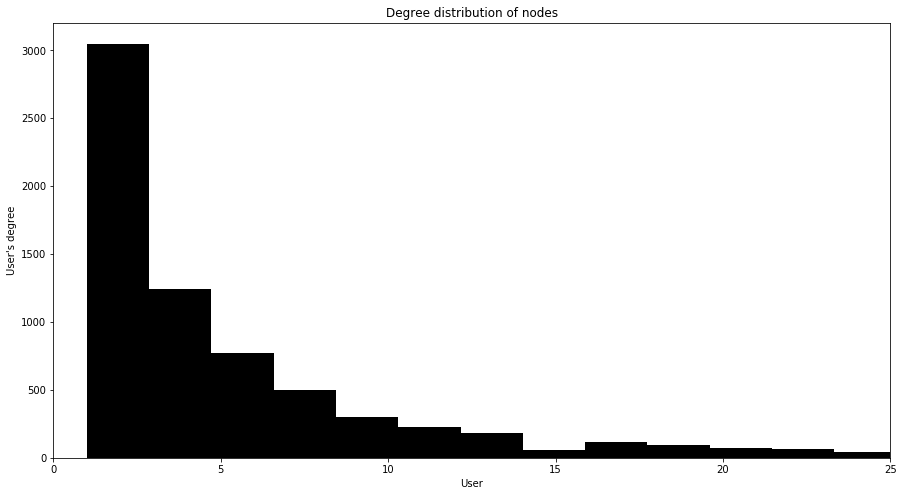

In [44]:
visual1(Graph)

# Visualization 2 
Visualize the best user! Plot the input node and a subset of its neighbouring nodes such that the user can get a grasp of the importance of this input node. Also split the interval of time into equidistant ranges of time and show the metric evolution over time.

In [47]:
def fetchvicini(Graph,u): 
    #this function will get the neighbors
    #of given node, then find out the edges 
    #between those nodes.
    neigh = [v for v in Graph.neighbors(u)]
    neigh.append(u)
    edgelist=[]
    for node1 in neigh:
        for node2 in neigh:
            if (node1,node2) in Graph.edges:
                edgelist.append ((node1,node2))
            if (node2,node1) in Graph.edges:
                edgelist.append((node2,node1))
    return neigh,edgelist

In [54]:
def scratchvicini(Graph,u,time_interval):
    t1 = date_to_timestamp(time_interval[0])
    t2 = date_to_timestamp(time_interval[1])
    upd = (t2-t1)/3
    G1=Graph.copy()
    G1=filtering(G1,(timestamp_to_date(t1),timestamp_to_date(t1+upd)))
    G2=Graph.copy()
    G2=filtering(G2,(timestamp_to_date(t1),timestamp_to_date(t1+(2*upd))))
    G3=Graph.copy()
    G3=filtering(G3,(timestamp_to_date(t1),timestamp_to_date(t2)))
    neigh,edgelist = fetchvicini(G1,u) 
    print(("scenario till {}, with {} nodes in total and {} edges").format(timestamp_to_date(t1+upd),len(neigh),len(edgelist)))
    plt.figure(1)
    nx.draw_networkx(G1, nodelist=neigh, edgelist=edgelist, node_size=600, node_color="tab:red",width=0.9, with_labels = False, cmap='Green', edge_cmap='Reds')
    plt.show()
    neigh,edgelist = fetchvicini(G2,u) 
    print(("scenario till {}, with {} nodes in total and {} edges").format(timestamp_to_date(t1+ (2*upd)),len(neigh),len(edgelist)))
    plt.figure(2)
    nx.draw_networkx(G2, nodelist=neigh, edgelist=edgelist, node_size=600, node_color="tab:red" ,width=0.9, with_labels = False, cmap='Green', edge_cmap='Reds')
    plt.show()
    neigh,edgelist = fetchvicini(G3,u)     
    print(("scenario till {}, with {} nodes in total and {} edges").format(timestamp_to_date(t2),len(neigh),len(edgelist)))
    plt.figure(3)
    nx.draw_networkx(G3, nodelist=neigh, edgelist=edgelist, node_size=600, node_color="tab:red",width=0.9, with_labels = False, cmap='Green', edge_cmap='Reds')
    plt.show()
    return

In [55]:
def visual2(Graph, u, metric, time_interval, alpha=0.2):
    dist(Graph, u, metric, time_interval, alpha=0.2)
    scratchvicini(Graph,u,time_interval)
    return

scenario till 06 March, 2009, with 5 nodes in total and 8 edges


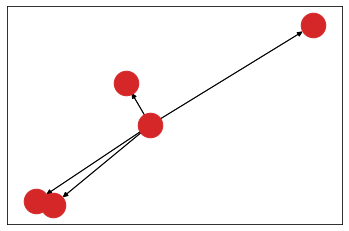

scenario till 08 March, 2009, with 6 nodes in total and 12 edges


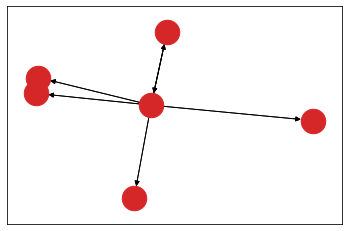

scenario till 10 March, 2009, with 6 nodes in total and 12 edges


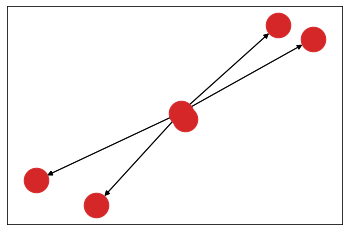

In [56]:
visual2(Graph,9345,'Degree',('05 March, 2009', '10 March, 2009'))

# Visualization 3 
Visualize the Shortest Ordered Route Once the user runs Functionality 3, we want the system to show in output the Shortest Ordered Route.

In [94]:
def funPath(path):  
    neigh=[]
    edgelist=[]
    edges = []
    for i in range(len(path)-1):
        edge = (path[i],path[i+1])
        edges.append(edge)
    #here we find out the neighbours of the 
    #nodes in the path for highlighting
    for node in path:
        neighbor = fetchvicini(Graph,node)
        neigh.extend(neighbor[0])
        edgelist.extend(neighbor[1])
    #highlighting the edges of the path
    highlight = edges
    edge_colors = ['grey' if not edge in highlight else 'black' for edge in edgelist]
    plt.figure(figsize=(10,10),dpi=120)
    width = [0.3 if not edge in highlight else 4 for edge in edgelist]
    nx.draw(Graph, nodelist = neigh,pos=nx.random_layout(Graph), arrowsize = 15,edgelist = edgelist, node_size=800,node_color="tab:red", width=width, with_labels = False, edge_color=edge_colors)
    plt.show()
    return 

In [95]:
def visual3(Graph,time_interval,users,source,target):
    path_ = path(Graph,time_interval,users,source,target)[1]
    funPath(path_)
    print(path_)
    return   

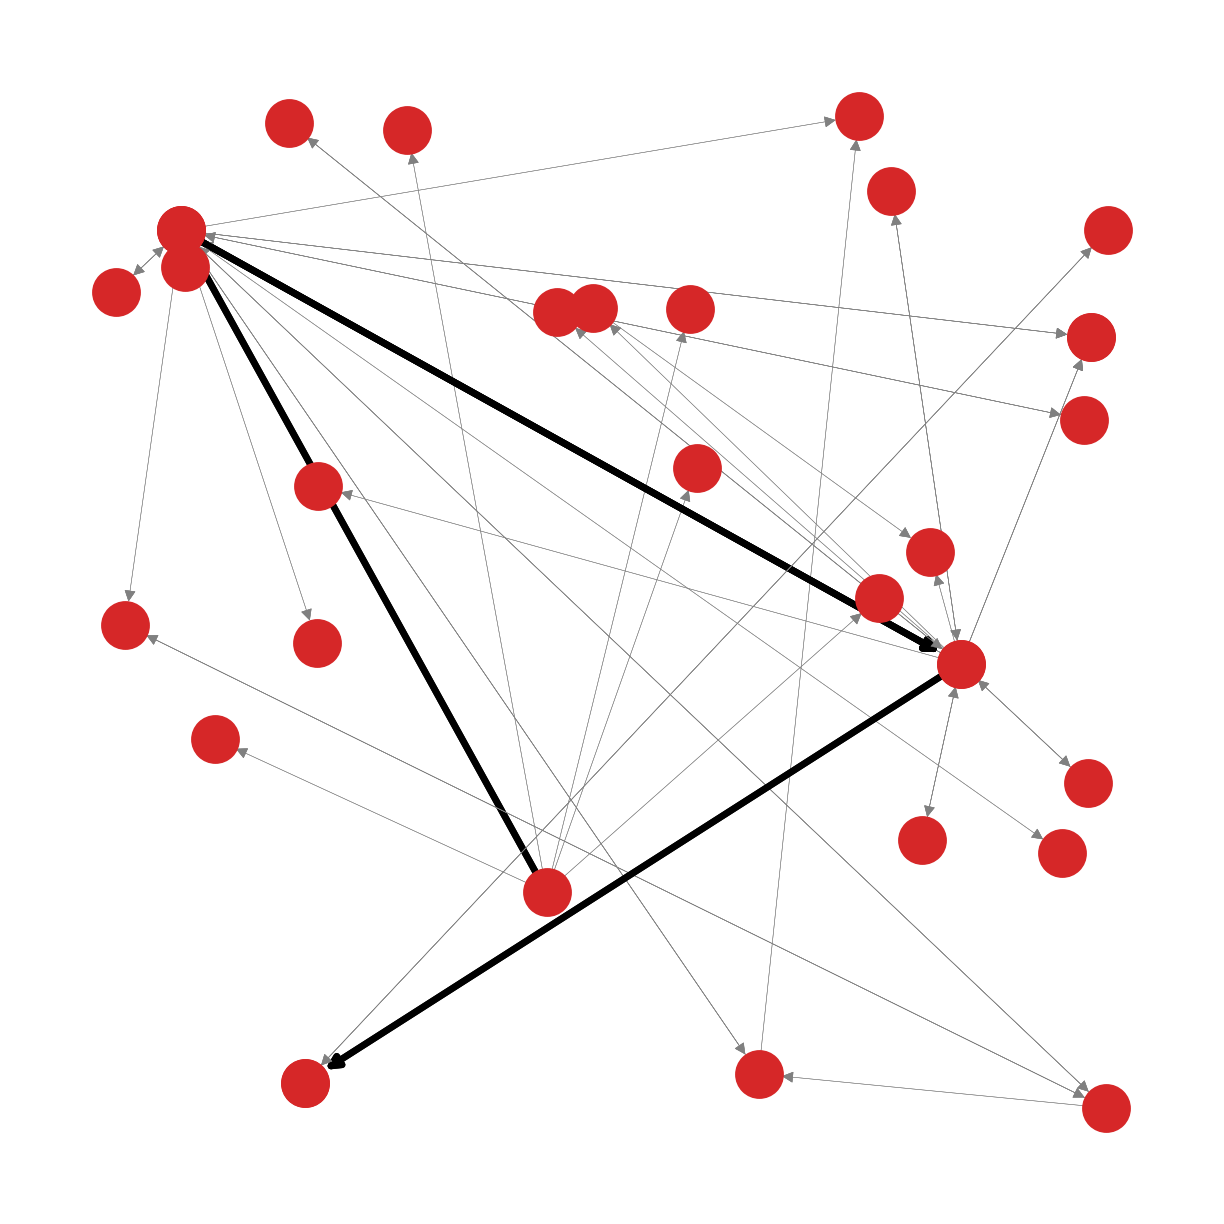

[414876, 72859, 1585, 53055]


In [96]:
visual3(Graph,('04 March, 2009', '06 March, 2009'),[72859,1585],414876, 53055)


# Visualization 4 
Visualize disconnecting graphs Show a visualization of the links needed to be removed in order to disconnect both graphs.

In [97]:
def funCutlinks(edges,Graph):    
    neigh=[]
    edgelist=[]
    #here we find the neighbors of the nodes 
    #in the edges to cut in order for highlighting
    for i in edges:
        for node in i:
            neighbor = fetchvicini(Graph,node)
            neigh.extend(neighbor[0])
            edgelist.extend(neighbor[1])
    edgelist.extend(edges)   
    #highlighting the edges 
    highlight = edges
    edge_colors = ['grey' if not edge in highlight else 'black' for edge in edgelist]
    plt.figure(figsize=(10,10),dpi=120)
    width = [0.3 if not edge in highlight else 4 for edge in edgelist]
    nx.draw(Graph, nodelist = neigh,pos=nx.spring_layout(Graph), arrowsize = 20,edgelist = edgelist, node_size=800,node_color="tab:red", width=width, with_labels = False, edge_color=edge_colors)
    plt.show()
    return

In [98]:
def visual4(Graph,time_interval,u1,u2):
    links,edges = disconnect(Graph,time_interval,u1,u2)
    funCutlinks(edges,Graph)
    return

atleast1links to cut with a total weight of 2.0


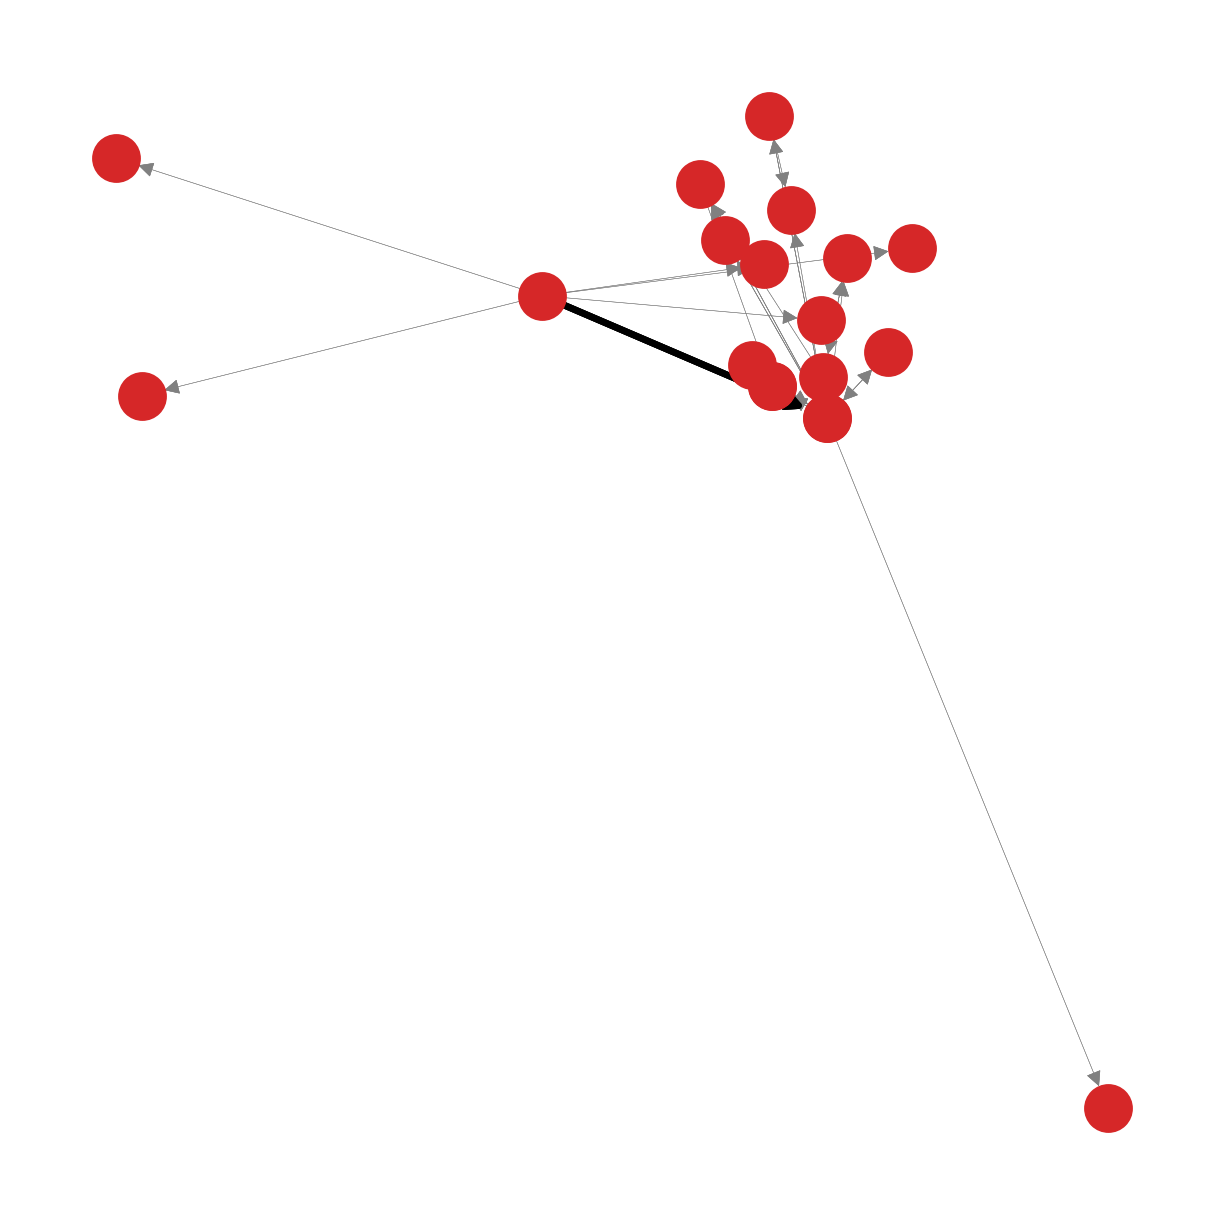

In [100]:
visual4(Graph,('04 March, 2009', '05 March, 2009'),414876,1585)


# 4. Algorithmic question
A number n of kids are in a camp. Between some k pairs of them (a kid can be part of more than one pairs) there are often fights. At night there are two dormitories where the kids can sleep. We want, if possible, to assign each kid in one of the two dormitories in such a way that each pair of kids that fights often is assigned to a different dormitory. (There are no space problems and the two dormitories can have different number of kids.)

Give an algorithm that is linear in n and k that is able to answer whether such an assignment is possible and, if so, return one.

In [163]:
def fun(kids, pairs):
    dormitory1 = [] #for dormitory 1
    dormitory2 = [] #for dormitory 2
    checked = [] #for checking record 
    for i in pairs:
        if (i[0] not in checked) & (i[1] not in checked):
            checked.append(i[0]) #checked in
            checked.append(i[1]) #checked in
            dormitory1.append(i[0]) #assigning to dormitory 1
            dormitory2.append(i[1]) #assigning to dormitory 2
        elif (i[0] in checked) & (i[1] not in checked):
            if i[0] in dormitory1 :
                dormitory2.append(i[1]) #assigning to dormitory 2
                checked.append(i[1]) #checked in
            else :
                dormitory1.append(i[1]) #assigning to dormitory 1
                checked.append(i[1]) #checked in
        elif (i[0] not in checked) & (i[1] in checked):
            if i[1] in dormitory1 :
                dormitory2.append(i[0]) #same
                checked.append(i[0]) #same
            else :
                dormitory1.append(i[0]) #same
                checked.append(i[0]) #same
    #assigning the rest of the kids in dormitory 2 ( we ould add also in dormitory 1 its idem)
    for j in kids:
        if j not in checked:
            dormitory2.append(j) #assigning to dormitory 2
            checked.append(j)    #checked in
    counter = 0 
    for i in pairs: #checking if two fighitng kids are assigned in the same dormitory.
        #we will use ".count" function which returns the number of elements with the specified value,
        #in this case it is running through each assigned stundents on dormitories.
        #Then using "and" logical function we find out if two fighitng kids are in the same dormitory. 
        if ((dormitory1.count(i[0]) != 0) and (dormitory1.count(i[1]) != 0)) \
        or ((dormitory2.count(i[0]) != 0) and (dormitory2.count(i[1]) != 0)):
            counter = counter + 1
    if counter == 0: 
        print('Kids assigned in dormitory 1:', dormitory1)
        print('Kids assigned in dormitory 2:', dormitory2) #no fighing pair in the same dormitory
    else:
        print("No way to seperate the fighting kids!")  #fighting pair in the same dormitory
    
       

# Checking with some example

In [164]:
pairs = [(1,3),(4,1),(2,4)]
kids = [1,2,3,4,5,6]
fun(kids, pairs)

Kids assigned in dormitory 1: [1, 2]
Kids assigned in dormitory 2: [3, 4, 5, 6]


In [165]:
pairs = [(1,2),(5,1),(3,6)]
kids = [1,2,3,4,5,6]
fun(kids,pairs)

Kids assigned in dormitory 1: [1, 3]
Kids assigned in dormitory 2: [2, 5, 6, 4]


In [166]:
pairs = [(1,6),(2,6),(5,6),(1,5)]
kids = [1,2,3,4,5,6]
fun(kids,pairs)

No way to seperate the fighting kids!
